In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import umap

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans


In [2]:
def expression_data():
   data = pd.read_csv('../data/data.csv')
   data = data.T
   data = data.drop(data.index[:3])
   return data

def pca(data):
    '''PCA'''
    # Select only the expression data columns for PCA
    expression_data = data

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(expression_data)

    # Apply PCA
    pca = PCA(n_components=2)  # You can change the number of components as needed
    principal_components = pca.fit_transform(scaled_data)
    return principal_components,scaled_data

def tsne(data):
    selected_columns = data
    tsne = TSNE(n_components=2, perplexity=30)  # Adjust parameters as needed

    # Perform t-SNE
    tsne_result = tsne.fit_transform(selected_columns)
    return tsne_result

def Umap(data):
    selected_columns = data  
    umap_reducer = umap.UMAP(n_components=2)  

    umap_result = umap_reducer.fit_transform(selected_columns)
    return umap_result

def ica(data):
    gene_expression = data
    ica = FastICA(n_components=2, random_state=42)


    ica.fit(gene_expression)

    independent_components = ica.transform(gene_expression)
    return independent_components

def vae(data):
    expression_data = data.values


    expression_data = (expression_data - np.min(expression_data)) / (np.max(expression_data) - np.min(expression_data))
    expression_data = tf.convert_to_tensor(expression_data, dtype=tf.float32)
    latent_dim = 2 

    encoder_inputs = keras.Input(shape=(expression_data.shape[1],))
    x = keras.layers.Dense(256, activation='relu')(encoder_inputs)
    x = keras.layers.Dense(128, activation='relu')(x)
    z_mean = keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    decoder_inputs = keras.layers.Dense(128, activation='relu')(z)
    decoder_outputs = keras.layers.Dense(expression_data.shape[1], activation='sigmoid')(decoder_inputs)

    vae = keras.Model(encoder_inputs, decoder_outputs)

    reconstruction_loss = tf.keras.losses.mean_squared_error(encoder_inputs, decoder_outputs)
    reconstruction_loss *= expression_data.shape[1]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    vae.fit(expression_data, epochs=20, batch_size=32)

    encoder = keras.Model(encoder_inputs, z_mean)
    encoded_data = encoder.predict(expression_data)
    return encoded_data

Silhouette Score: -0.0648100700076673
Normalized Mutual Information (NMI): 0.17764665990659942
Adjusted Rand Index (ARI) for PCA: -0.0009519363474929836


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


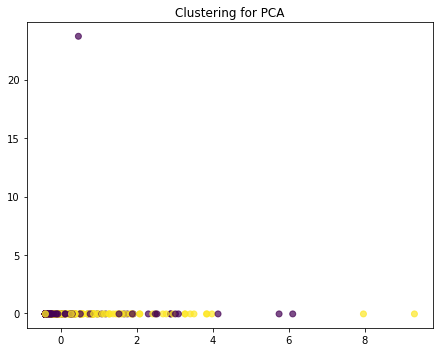

In [59]:
#ARI for PCA
num_clusters = 2 
pca_result,scaled_data = pca(expression_data())

# Perform K-means clustering
kmeans1 = KMeans(n_clusters=num_clusters,init='random')  
cluster_labels1 = kmeans1.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

kmeans2 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
cluster_labels2 = kmeans2.fit_predict(scaled_data)  # Fit the model and obtain cluster labels
ari = adjusted_rand_score(cluster_labels1,cluster_labels2)
nmi = normalized_mutual_info_score(cluster_labels1,cluster_labels2)
silhouette_avg = silhouette_score(cluster_labels1.reshape(-1, 1),cluster_labels2.reshape(-1, 1))
print(f"Silhouette Score: {silhouette_avg}")
print(f"Normalized Mutual Information (NMI): {nmi}")
print(f"Adjusted Rand Index (ARI) for PCA: {ari}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=cluster_labels1, cmap='viridis', alpha=0.7)
plt.title('Clustering for PCA')

plt.tight_layout()
plt.show()


d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Silhouette Score: 0.9474507043406372
Normalized Mutual Information (NMI): 0.8846277235523203
Adjusted Rand Index (ARI) for PCA: 0.9298603010234544


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


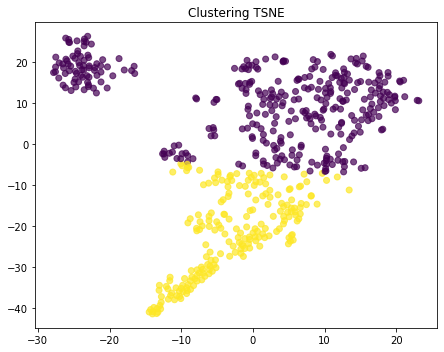

In [60]:
#Eval for TSNE

num_clusters = 2 # Change this to the number of clusters you want
scaled_data = tsne(expression_data())
# Perform K-means clustering
kmeans1 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
cluster_labels1 = kmeans1.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

kmeans2 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
cluster_labels2 = kmeans2.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

ari = adjusted_rand_score(cluster_labels1,cluster_labels2)
nmi = normalized_mutual_info_score(cluster_labels1,cluster_labels2)
silhouette_avg = silhouette_score(cluster_labels1.reshape(-1, 1),cluster_labels2.reshape(-1, 1))
print(f"Silhouette Score: {silhouette_avg}")
print(f"Normalized Mutual Information (NMI): {nmi}")
print(f"Adjusted Rand Index (ARI) for PCA: {ari}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=cluster_labels1, cmap='viridis', alpha=0.7)
plt.title('Clustering TSNE')

plt.tight_layout()
plt.show()

Silhouette Score: 1.0
Normalized Mutual Information (NMI): 1.0
Adjusted Rand Index (ARI) for PCA: 1.0


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


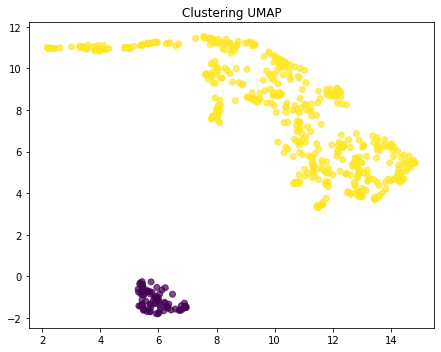

In [56]:
#Eval for UMAP

num_clusters = 2 # Change this to the number of clusters you want
scaled_data = Umap(expression_data())
# Perform K-means clustering
kmeans1 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
cluster_labels1 = kmeans1.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

kmeans2 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
cluster_labels2 = kmeans2.fit_predict(scaled_data)  # Fit the model and obtain cluster labels
ari = adjusted_rand_score(cluster_labels1,cluster_labels2)
nmi = normalized_mutual_info_score(cluster_labels1,cluster_labels2)
silhouette_avg = silhouette_score(cluster_labels1.reshape(-1, 1),cluster_labels2.reshape(-1, 1))
print(f"Silhouette Score: {silhouette_avg}")
print(f"Normalized Mutual Information (NMI): {nmi}")
print(f"Adjusted Rand Index (ARI) for PCA: {ari}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=cluster_labels1, cmap='viridis', alpha=0.7)
plt.title('Clustering UMAP')

plt.tight_layout()
plt.show()

Silhouette Score: 1.0
Normalized Mutual Information (NMI): 1.0
Adjusted Rand Index (ARI) for PCA: 1.0


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


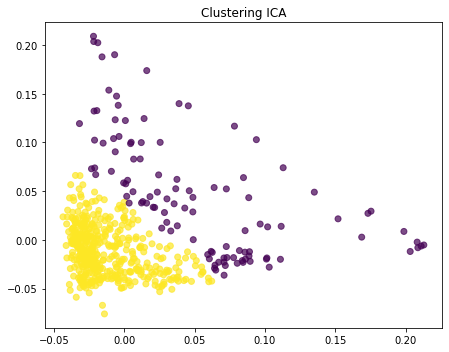

In [63]:
#Eval for ICA
num_clusters = 2 # Change this to the number of clusters you want
scaled_data = ica(expression_data())
# Perform K-means clustering
kmeans1 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
cluster_labels1 = kmeans1.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

kmeans2 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
cluster_labels2 = kmeans2.fit_predict(scaled_data)  # Fit the model and obtain cluster labels
ari = adjusted_rand_score(cluster_labels1,cluster_labels2)
nmi = normalized_mutual_info_score(cluster_labels1,cluster_labels2)
silhouette_avg = silhouette_score(cluster_labels1.reshape(-1, 1),cluster_labels2.reshape(-1, 1))
print(f"Silhouette Score: {silhouette_avg}")
print(f"Normalized Mutual Information (NMI): {nmi}")
print(f"Adjusted Rand Index (ARI) for PCA: {ari}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=cluster_labels1, cmap='viridis', alpha=0.7)
plt.title('Clustering ICA')
plt.tight_layout()
plt.show()


Epoch 1/20
18/18 [==============================] - 5s 226ms/step - loss: 13226.2148
Epoch 2/20
18/18 [==============================] - 4s 221ms/step - loss: 8958.0488
Epoch 3/20
18/18 [==============================] - 4s 218ms/step - loss: 2516.9424
Epoch 4/20
18/18 [==============================] - 4s 213ms/step - loss: 318.1449
Epoch 5/20
18/18 [==============================] - 4s 214ms/step - loss: 162.5407
Epoch 6/20
18/18 [==============================] - 4s 212ms/step - loss: 160.8917
Epoch 7/20
18/18 [==============================] - 4s 217ms/step - loss: 127.6732
Epoch 8/20
18/18 [==============================] - 4s 214ms/step - loss: 134.6723
Epoch 9/20
18/18 [==============================] - 4s 227ms/step - loss: 156.4456
Epoch 10/20
18/18 [==============================] - 4s 239ms/step - loss: 117.1000
Epoch 11/20
18/18 [==============================] - 4s 228ms/step - loss: 158.5092
Epoch 12/20
18/18 [==============================] - 4s 240ms/step - loss: 134.39

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


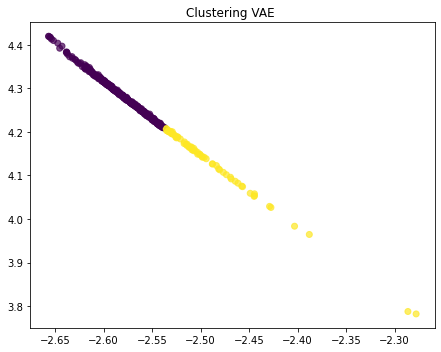

In [61]:
#Eval for VAE
num_clusters = 2 # Change this to the number of clusters you want
scaled_data = vae(expression_data())
# Perform K-means clustering
kmeans1 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
cluster_labels1 = kmeans1.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

kmeans2 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
cluster_labels2 = kmeans2.fit_predict(scaled_data)  # Fit the model and obtain cluster labels
ari = adjusted_rand_score(cluster_labels1,cluster_labels2)
nmi = normalized_mutual_info_score(cluster_labels1,cluster_labels2)
silhouette_avg = silhouette_score(cluster_labels1.reshape(-1, 1),cluster_labels2.reshape(-1, 1))
print(f"Silhouette Score: {silhouette_avg}")
print(f"Normalized Mutual Information (NMI): {nmi}")
print(f"Adjusted Rand Index (ARI) for PCA: {ari}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=cluster_labels1, cmap='viridis', alpha=0.7)
plt.title('Clustering VAE ')

plt.tight_layout()
plt.show()



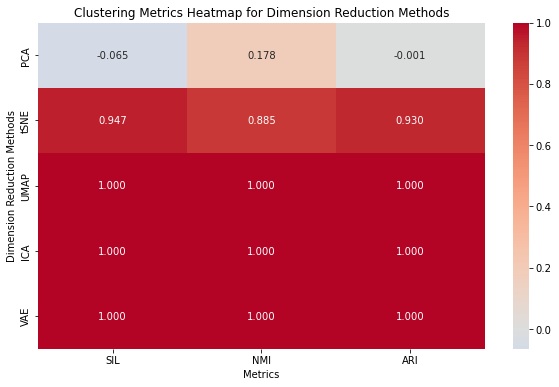

In [66]:
'''
PCA:
Silhouette Score: -0.0648100700076673
Normalized Mutual Information (NMI): 0.17764665990659942
Adjusted Rand Index (ARI) for PCA: -0.0009519363474929836

tSNE:
Silhouette Score: 0.9474507043406372
Normalized Mutual Information (NMI): 0.8846277235523203
Adjusted Rand Index (ARI) for PCA: 0.9298603010234544

UMAP
Silhouette Score: 1.0
Normalized Mutual Information (NMI): 1.0
Adjusted Rand Index (ARI) for PCA: 1.0

ICA
Silhouette Score: 1.0
Normalized Mutual Information (NMI): 1.0
Adjusted Rand Index (ARI) for PCA: 1.0

VAE
Silhouette Score: 1.0
Normalized Mutual Information (NMI): 1.0
Adjusted Rand Index (ARI) for PCA: 1.0
'''
import seaborn as sns

# Creating a DataFrame with the given scores
data = {
    'Method': ['PCA', 'tSNE', 'UMAP', 'ICA', 'VAE'],
    'SIL': [-0.0648100700076673, 0.9474507043406372, 1.0, 1.0, 1.0],
    'NMI': [0.17764665990659942, 0.8846277235523203, 1.0, 1.0, 1.0],
    'ARI': [-0.0009519363474929836, 0.9298603010234544, 1.0, 1.0, 1.0]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Set 'Method' column as index for better visualization
df.set_index('Method', inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='coolwarm', center=0, fmt=".3f")
plt.title('Clustering Metrics Heatmap for Dimension Reduction Methods')
plt.xlabel('Metrics')
plt.ylabel('Dimension Reduction Methods')
plt.show()

In [67]:
#sensitivity model for TSNE

def tsne(data,p):
  selected_columns = data
  tsne = TSNE(n_components=2, perplexity=p)  # Adjust parameters as needed

  # Perform t-SNE
  tsne_result = tsne.fit_transform(selected_columns)
  return tsne_result

perplexities = []
ari_all = []
nmi_all = []
sil_all = []
for p in range(1,51):
  num_clusters = 2 # Change this to the number of clusters you want
  scaled_data = tsne(expression_data(),p)
  # Perform K-means clustering
  kmeans1 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
  cluster_labels1 = kmeans1.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

  kmeans2 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
  cluster_labels2 = kmeans2.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

  ari = adjusted_rand_score(cluster_labels1,cluster_labels2)
  nmi = normalized_mutual_info_score(cluster_labels1,cluster_labels2)
  sil = silhouette_score(cluster_labels1.reshape(-1, 1),cluster_labels2.reshape(-1, 1))
  ari_all.append(ari)
  nmi_all.append(nmi)
  sil_all.append(sil)
  perplexities.append(p)





d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d

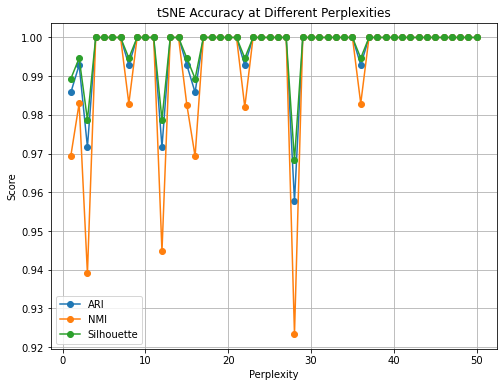

In [69]:
# Plotting the data
plt.figure(figsize=(8, 6))

# Plot ARI
plt.plot(perplexities, ari_all, marker='o', linestyle='-', label='ARI')

# Plot NMI
plt.plot(perplexities, nmi_all, marker='o', linestyle='-', label='NMI')

# Plot Silhouette Score
plt.plot(perplexities, sil_all, marker='o', linestyle='-', label='Silhouette')

# Adding labels and title
plt.xlabel('Perplexity')
plt.ylabel('Score')
plt.title('tSNE Accuracy at Different Perplexities')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
#sensitivity model for UMAP
def Umap(data,n_neighbors,min_dist,metric):
    selected_columns = data  
    umap_reducer = umap.UMAP(n_components=2,n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric) 

    umap_result = umap_reducer.fit_transform(selected_columns)
    return umap_result


perplexities = []
ari_all = []
nmi_all = []
sil_all = []
i = 1
for n_neighbor in [2,  5,  10,  20,  100]:
  for distance in [0,  0.1,  0.25,  0.5,   1]:
    for metric in ['correlation',  'euclidean',   'minkowski']:
      num_clusters = 2 # Change this to the number of clusters you want
      scaled_data = Umap(expression_data(),n_neighbor,distance,metric)
      # Perform K-means clustering
      kmeans1 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
      cluster_labels1 = kmeans1.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

      kmeans2 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
      cluster_labels2 = kmeans2.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

      ari = adjusted_rand_score(cluster_labels1,cluster_labels2)
      nmi = normalized_mutual_info_score(cluster_labels1,cluster_labels2)
      sil = silhouette_score(cluster_labels1.reshape(-1, 1),cluster_labels2.reshape(-1, 1))
      ari_all.append(ari)
      nmi_all.append(nmi)
      sil_all.append(sil)
      perplexities.append(i)
      i += 1

d:\CS Software\anaconda3\lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to ran

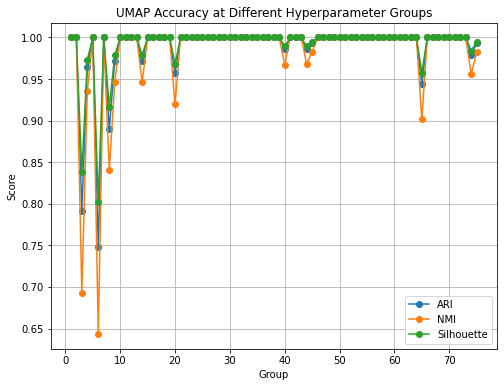

In [74]:
# Plotting the data
plt.figure(figsize=(8, 6))

# Plot ARI
plt.plot(perplexities, ari_all, marker='o', linestyle='-', label='ARI')

# Plot NMI
plt.plot(perplexities, nmi_all, marker='o', linestyle='-', label='NMI')

# Plot Silhouette Score
plt.plot(perplexities, sil_all, marker='o', linestyle='-', label='Silhouette')

# Adding labels and title
plt.xlabel('Group')
plt.ylabel('Score')
plt.title('UMAP Accuracy at Different Hyperparameter Groups')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
#sensitivity model for VAE
def vae(data,e,b):
    expression_data = data.values


    expression_data = (expression_data - np.min(expression_data)) / (np.max(expression_data) - np.min(expression_data))
    expression_data = tf.convert_to_tensor(expression_data, dtype=tf.float32)
    latent_dim = 2 

    encoder_inputs = keras.Input(shape=(expression_data.shape[1],))
    x = keras.layers.Dense(256, activation='relu')(encoder_inputs)
    x = keras.layers.Dense(128, activation='relu')(x)
    z_mean = keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    decoder_inputs = keras.layers.Dense(128, activation='relu')(z)
    decoder_outputs = keras.layers.Dense(expression_data.shape[1], activation='sigmoid')(decoder_inputs)

    vae = keras.Model(encoder_inputs, decoder_outputs)

    reconstruction_loss = tf.keras.losses.mean_squared_error(encoder_inputs, decoder_outputs)
    reconstruction_loss *= expression_data.shape[1]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    vae.fit(expression_data, epochs=e, batch_size=b)

    encoder = keras.Model(encoder_inputs, z_mean)
    encoded_data = encoder.predict(expression_data)
    return encoded_data

perplexities = []
ari_all = []
nmi_all = []
sil_all = []
i = 1
df = expression_data()
for e in [5, 10,  15,  20]:
  for b in [5,  10,  20, 30, 40]:
      num_clusters = 2 # Change this to the number of clusters you want
      scaled_data = vae(df,e,b)
      # Perform K-means clustering
      kmeans1 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
      cluster_labels1 = kmeans1.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

      kmeans2 = KMeans(n_clusters=num_clusters,init='random')  # Create a KMeans instance
      cluster_labels2 = kmeans2.fit_predict(scaled_data)  # Fit the model and obtain cluster labels

      ari = adjusted_rand_score(cluster_labels1,cluster_labels2)
      nmi = normalized_mutual_info_score(cluster_labels1,cluster_labels2)
      sil = silhouette_score(cluster_labels1.reshape(-1, 1),cluster_labels2.reshape(-1, 1))
      ari_all.append(ari)
      nmi_all.append(nmi)
      sil_all.append(sil)
      perplexities.append(i)
      i += 1



Epoch 1/5
113/113 [==============================] - 24s 202ms/step - loss: 4904.6099
Epoch 2/5
113/113 [==============================] - 23s 204ms/step - loss: 182.0656
Epoch 3/5
113/113 [==============================] - 22s 199ms/step - loss: 97.6396
Epoch 4/5
113/113 [==============================] - 22s 198ms/step - loss: 104.5028
Epoch 5/5
18/18 [==============================] - 0s 9ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/5
57/57 [==============================] - 13s 203ms/step - loss: 8268.3838
Epoch 2/5
57/57 [==============================] - 11s 199ms/step - loss: 220.3215
Epoch 3/5
57/57 [==============================] - 11s 198ms/step - loss: 158.9403
Epoch 4/5
57/57 [==============================] - 11s 201ms/step - loss: 124.5652
Epoch 5/5
18/18 [==============================] - 0s 6ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/5
29/29 [==============================] - 7s 216ms/step - loss: 12188.9395
Epoch 2/5
29/29 [==============================] - 6s 218ms/step - loss: 3971.5229
Epoch 3/5
29/29 [==============================] - 6s 214ms/step - loss: 226.1703
Epoch 4/5
29/29 [==============================] - 6s 208ms/step - loss: 143.4515
Epoch 5/5
18/18 [==============================] - 0s 6ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/5
19/19 [==============================] - 5s 214ms/step - loss: 13162.7939
Epoch 2/5
19/19 [==============================] - 4s 216ms/step - loss: 8551.7676
Epoch 3/5
19/19 [==============================] - 4s 220ms/step - loss: 1923.1781
Epoch 4/5
19/19 [==============================] - 4s 225ms/step - loss: 257.5409
Epoch 5/5
18/18 [==============================] - 0s 10ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/5
15/15 [==============================] - 4s 222ms/step - loss: 13367.5889
Epoch 2/5
15/15 [==============================] - 3s 226ms/step - loss: 10304.4668
Epoch 3/5
15/15 [==============================] - 3s 226ms/step - loss: 3572.6409
Epoch 4/5
15/15 [==============================] - 3s 219ms/step - loss: 375.2089
Epoch 5/5
18/18 [==============================] - 0s 12ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/10
113/113 [==============================] - 24s 201ms/step - loss: 4507.6753
Epoch 2/10
113/113 [==============================] - 23s 200ms/step - loss: 166.5246
Epoch 3/10
113/113 [==============================] - 23s 203ms/step - loss: 155.8246
Epoch 4/10
113/113 [==============================] - 23s 203ms/step - loss: 121.7796
Epoch 5/10
113/113 [==============================] - 23s 202ms/step - loss: 94.8968
Epoch 6/10
113/113 [==============================] - 23s 201ms/step - loss: 77.7272
Epoch 7/10
113/113 [==============================] - 23s 200ms/step - loss: 62.0869
Epoch 8/10
113/113 [==============================] - 22s 199ms/step - loss: 52.2712
Epoch 9/10
113/113 [==============================] - 23s 201ms/step - loss: 45.6007
Epoch 10/10
18/18 [==============================] - 0s 8ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/10
57/57 [==============================] - 14s 215ms/step - loss: 7972.1128
Epoch 2/10
57/57 [==============================] - 12s 205ms/step - loss: 204.8809
Epoch 3/10
57/57 [==============================] - 11s 201ms/step - loss: 134.2185
Epoch 4/10
57/57 [==============================] - 12s 202ms/step - loss: 153.2840
Epoch 5/10
57/57 [==============================] - 11s 202ms/step - loss: 119.9516
Epoch 6/10
57/57 [==============================] - 11s 201ms/step - loss: 120.8602
Epoch 7/10
57/57 [==============================] - 11s 201ms/step - loss: 110.5868
Epoch 8/10
57/57 [==============================] - 12s 202ms/step - loss: 91.2828
Epoch 9/10
57/57 [==============================] - 11s 202ms/step - loss: 80.9900
Epoch 10/10
18/18 [==============================] - 0s 7ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/10
29/29 [==============================] - 7s 212ms/step - loss: 11977.1885
Epoch 2/10
29/29 [==============================] - 6s 210ms/step - loss: 3412.2131
Epoch 3/10
29/29 [==============================] - 6s 207ms/step - loss: 46.2407
Epoch 4/10
29/29 [==============================] - 6s 207ms/step - loss: 19.3693
Epoch 5/10
29/29 [==============================] - 6s 207ms/step - loss: 19.1313
Epoch 6/10
29/29 [==============================] - 6s 209ms/step - loss: 16.5404
Epoch 7/10
29/29 [==============================] - 6s 215ms/step - loss: 16.5336
Epoch 8/10
29/29 [==============================] - 6s 211ms/step - loss: 15.1163
Epoch 9/10
29/29 [==============================] - 6s 205ms/step - loss: 14.0045
Epoch 10/10
18/18 [==============================] - 0s 8ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/10
19/19 [==============================] - 5s 214ms/step - loss: 13056.6738
Epoch 2/10
19/19 [==============================] - 4s 213ms/step - loss: 7800.2090
Epoch 3/10
19/19 [==============================] - 4s 211ms/step - loss: 1517.5289
Epoch 4/10
19/19 [==============================] - 4s 212ms/step - loss: 313.6678
Epoch 5/10
19/19 [==============================] - 4s 213ms/step - loss: 185.6656
Epoch 6/10
19/19 [==============================] - 4s 214ms/step - loss: 162.8883
Epoch 7/10
19/19 [==============================] - 4s 212ms/step - loss: 185.0894
Epoch 8/10
19/19 [==============================] - 4s 211ms/step - loss: 188.4581
Epoch 9/10
19/19 [==============================] - 4s 214ms/step - loss: 136.5878
Epoch 10/10
18/18 [==============================] - 0s 8ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/10
15/15 [==============================] - 5s 220ms/step - loss: 13482.1914
Epoch 2/10
15/15 [==============================] - 3s 217ms/step - loss: 10859.4756
Epoch 3/10
15/15 [==============================] - 3s 217ms/step - loss: 6585.4849
Epoch 4/10
15/15 [==============================] - 3s 220ms/step - loss: 1891.5142
Epoch 5/10
15/15 [==============================] - 3s 218ms/step - loss: 347.7905
Epoch 6/10
15/15 [==============================] - 3s 218ms/step - loss: 161.9196
Epoch 7/10
15/15 [==============================] - 3s 219ms/step - loss: 134.9788
Epoch 8/10
15/15 [==============================] - 3s 222ms/step - loss: 154.3226
Epoch 9/10
15/15 [==============================] - 3s 222ms/step - loss: 259.2273
Epoch 10/10
18/18 [==============================] - 0s 9ms/step


d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
113/113 [==============================] - 23s 196ms/step - loss: 4168.1274
Epoch 2/15
113/113 [==============================] - 22s 195ms/step - loss: 198.5150
Epoch 3/15
113/113 [==============================] - 22s 196ms/step - loss: 119.4055
Epoch 4/15
113/113 [==============================] - 22s 195ms/step - loss: 127.8701
Epoch 5/15
113/113 [==============================] - 22s 194ms/step - loss: 83.9763
Epoch 6/15
113/113 [==============================] - 22s 197ms/step - loss: 91.8387
Epoch 7/15
113/113 [==============================] - 22s 196ms/step - loss: 52.1512
Epoch 8/15
113/113 [==============================] - 22s 195ms/step - loss: 58.8845
Epoch 9/15
113/113 [==============================] - 23s 200ms/step - loss: 43.5834
Epoch 10/15
113/113 [==============================] - 22s 198ms/step - loss: 37.2507
Epoch 11/15
113/113 [==============================] - 22s 197ms/step - loss: 27.3868
Epoch 12/15
113/113 [==============================] - 22s

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
57/57 [==============================] - 12s 200ms/step - loss: 8649.3428
Epoch 2/15
57/57 [==============================] - 11s 198ms/step - loss: 306.5836
Epoch 3/15
57/57 [==============================] - 11s 199ms/step - loss: 48.2193
Epoch 4/15
57/57 [==============================] - 11s 198ms/step - loss: 39.3572
Epoch 5/15
57/57 [==============================] - 11s 198ms/step - loss: 30.1282
Epoch 6/15
57/57 [==============================] - 11s 201ms/step - loss: 25.5042
Epoch 7/15
57/57 [==============================] - 11s 201ms/step - loss: 19.9303
Epoch 8/15
57/57 [==============================] - 11s 202ms/step - loss: 17.2238
Epoch 9/15
57/57 [==============================] - 12s 202ms/step - loss: 15.5394
Epoch 10/15
57/57 [==============================] - 11s 200ms/step - loss: 15.9810
Epoch 11/15
57/57 [==============================] - 11s 199ms/step - loss: 13.2431
Epoch 12/15
57/57 [==============================] - 11s 198ms/step - loss: 12.513

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
29/29 [==============================] - 7s 217ms/step - loss: 12075.2871
Epoch 2/15
29/29 [==============================] - 6s 215ms/step - loss: 4281.9189
Epoch 3/15
29/29 [==============================] - 6s 221ms/step - loss: 270.9660
Epoch 4/15
29/29 [==============================] - 6s 208ms/step - loss: 190.5372
Epoch 5/15
29/29 [==============================] - 6s 203ms/step - loss: 142.5239
Epoch 6/15
29/29 [==============================] - 6s 202ms/step - loss: 125.2583
Epoch 7/15
29/29 [==============================] - 6s 202ms/step - loss: 134.5941
Epoch 8/15
29/29 [==============================] - 6s 201ms/step - loss: 108.9313
Epoch 9/15
29/29 [==============================] - 6s 203ms/step - loss: 116.6969
Epoch 10/15
29/29 [==============================] - 6s 204ms/step - loss: 124.9333
Epoch 11/15
29/29 [==============================] - 6s 200ms/step - loss: 150.2549
Epoch 12/15
29/29 [==============================] - 6s 199ms/step - loss: 128.183

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
19/19 [==============================] - 5s 229ms/step - loss: 13155.9395
Epoch 2/15
19/19 [==============================] - 4s 221ms/step - loss: 9013.1748
Epoch 3/15
19/19 [==============================] - 4s 217ms/step - loss: 2904.6023
Epoch 4/15
19/19 [==============================] - 4s 208ms/step - loss: 330.9389
Epoch 5/15
19/19 [==============================] - 4s 214ms/step - loss: 160.4702
Epoch 6/15
19/19 [==============================] - 4s 206ms/step - loss: 148.7302
Epoch 7/15
19/19 [==============================] - 4s 206ms/step - loss: 157.2252
Epoch 8/15
19/19 [==============================] - 4s 207ms/step - loss: 117.1761
Epoch 9/15
19/19 [==============================] - 4s 205ms/step - loss: 107.8816
Epoch 10/15
19/19 [==============================] - 4s 205ms/step - loss: 125.0202
Epoch 11/15
19/19 [==============================] - 4s 208ms/step - loss: 127.9071
Epoch 12/15
19/19 [==============================] - 4s 205ms/step - loss: 139.25

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
15/15 [==============================] - 4s 214ms/step - loss: 13474.7051
Epoch 2/15
15/15 [==============================] - 3s 214ms/step - loss: 10546.7031
Epoch 3/15
15/15 [==============================] - 3s 213ms/step - loss: 5763.9839
Epoch 4/15
15/15 [==============================] - 3s 219ms/step - loss: 1342.4651
Epoch 5/15
15/15 [==============================] - 3s 216ms/step - loss: 191.2234
Epoch 6/15
15/15 [==============================] - 3s 215ms/step - loss: 164.5775
Epoch 7/15
15/15 [==============================] - 3s 212ms/step - loss: 155.8184
Epoch 8/15
15/15 [==============================] - 3s 211ms/step - loss: 139.8276
Epoch 9/15
15/15 [==============================] - 3s 210ms/step - loss: 174.3877
Epoch 10/15
15/15 [==============================] - 3s 210ms/step - loss: 178.8221
Epoch 11/15
15/15 [==============================] - 3s 212ms/step - loss: 147.3818
Epoch 12/15
15/15 [==============================] - 3s 211ms/step - loss: 118.

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
113/113 [==============================] - 23s 196ms/step - loss: 4112.6763
Epoch 2/20
113/113 [==============================] - 22s 193ms/step - loss: 218.6998
Epoch 3/20
113/113 [==============================] - 22s 198ms/step - loss: 139.1662
Epoch 4/20
113/113 [==============================] - 22s 198ms/step - loss: 126.7597
Epoch 5/20
113/113 [==============================] - 22s 192ms/step - loss: 81.4276
Epoch 6/20
113/113 [==============================] - 22s 192ms/step - loss: 78.5347
Epoch 7/20
113/113 [==============================] - 22s 193ms/step - loss: 50.6024
Epoch 8/20
113/113 [==============================] - 22s 194ms/step - loss: 42.4875
Epoch 9/20
113/113 [==============================] - 22s 195ms/step - loss: 37.1982
Epoch 10/20
113/113 [==============================] - 22s 194ms/step - loss: 31.8409
Epoch 11/20
113/113 [==============================] - 22s 194ms/step - loss: 26.4412
Epoch 12/20
113/113 [==============================] - 22s

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
57/57 [==============================] - 12s 192ms/step - loss: 9104.1055
Epoch 2/20
57/57 [==============================] - 12s 203ms/step - loss: 396.3379
Epoch 3/20
57/57 [==============================] - 12s 205ms/step - loss: 145.8687
Epoch 4/20
57/57 [==============================] - 11s 197ms/step - loss: 174.0355
Epoch 5/20
57/57 [==============================] - 11s 198ms/step - loss: 106.1312
Epoch 6/20
57/57 [==============================] - 12s 212ms/step - loss: 69.1314
Epoch 7/20
57/57 [==============================] - 12s 209ms/step - loss: 104.2853
Epoch 8/20
57/57 [==============================] - 12s 204ms/step - loss: 74.0774
Epoch 9/20
57/57 [==============================] - 12s 208ms/step - loss: 81.5971
Epoch 10/20
57/57 [==============================] - 12s 202ms/step - loss: 75.1039
Epoch 11/20
57/57 [==============================] - 11s 200ms/step - loss: 51.6015
Epoch 12/20
57/57 [==============================] - 12s 210ms/step - loss: 78

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
29/29 [==============================] - 8s 223ms/step - loss: 11984.6631
Epoch 2/20
29/29 [==============================] - 6s 221ms/step - loss: 3336.1843
Epoch 3/20
29/29 [==============================] - 6s 222ms/step - loss: 237.4234
Epoch 4/20
29/29 [==============================] - 6s 221ms/step - loss: 142.7589
Epoch 5/20
29/29 [==============================] - 6s 205ms/step - loss: 116.2832
Epoch 6/20
29/29 [==============================] - 6s 205ms/step - loss: 169.2126
Epoch 7/20
29/29 [==============================] - 6s 205ms/step - loss: 117.4307
Epoch 8/20
29/29 [==============================] - 6s 216ms/step - loss: 143.8874
Epoch 9/20
29/29 [==============================] - 6s 205ms/step - loss: 201.3985
Epoch 10/20
29/29 [==============================] - 6s 207ms/step - loss: 139.4063
Epoch 11/20
29/29 [==============================] - 6s 202ms/step - loss: 125.2328
Epoch 12/20
29/29 [==============================] - 6s 202ms/step - loss: 102.791

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
19/19 [==============================] - 5s 225ms/step - loss: 13046.6602
Epoch 2/20
19/19 [==============================] - 4s 223ms/step - loss: 7509.1382
Epoch 3/20
19/19 [==============================] - 4s 219ms/step - loss: 1181.8481
Epoch 4/20
19/19 [==============================] - 4s 219ms/step - loss: 233.4433
Epoch 5/20
19/19 [==============================] - 4s 219ms/step - loss: 214.0461
Epoch 6/20
19/19 [==============================] - 4s 221ms/step - loss: 163.6449
Epoch 7/20
19/19 [==============================] - 4s 218ms/step - loss: 166.7301
Epoch 8/20
19/19 [==============================] - 4s 213ms/step - loss: 159.4342
Epoch 9/20
19/19 [==============================] - 4s 214ms/step - loss: 148.8424
Epoch 10/20
19/19 [==============================] - 4s 212ms/step - loss: 170.9075
Epoch 11/20
19/19 [==============================] - 4s 216ms/step - loss: 168.2185
Epoch 12/20
19/19 [==============================] - 4s 212ms/step - loss: 163.35

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
15/15 [==============================] - 4s 222ms/step - loss: 13434.9395
Epoch 2/20
15/15 [==============================] - 3s 218ms/step - loss: 10304.8066
Epoch 3/20
15/15 [==============================] - 3s 217ms/step - loss: 4839.1191
Epoch 4/20
15/15 [==============================] - 3s 217ms/step - loss: 1070.4396
Epoch 5/20
15/15 [==============================] - 3s 219ms/step - loss: 218.7903
Epoch 6/20
15/15 [==============================] - 3s 219ms/step - loss: 275.5180
Epoch 7/20
15/15 [==============================] - 3s 218ms/step - loss: 211.2445
Epoch 8/20
15/15 [==============================] - 3s 221ms/step - loss: 183.1041
Epoch 9/20
15/15 [==============================] - 3s 217ms/step - loss: 142.6018
Epoch 10/20
15/15 [==============================] - 3s 221ms/step - loss: 156.7726
Epoch 11/20
15/15 [==============================] - 3s 219ms/step - loss: 130.9549
Epoch 12/20
15/15 [==============================] - 3s 220ms/step - loss: 123.

d:\CS Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


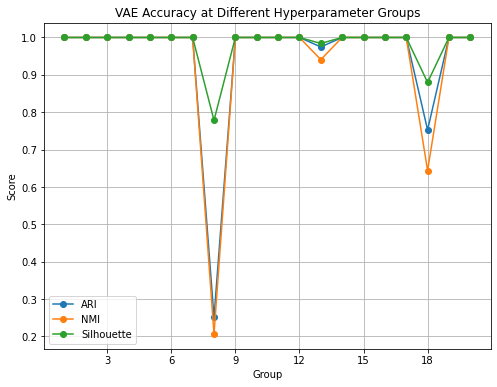

In [79]:
import matplotlib.ticker as ticker

# Plotting the data
plt.figure(figsize=(8, 6))

# Plot ARI
plt.plot(perplexities, ari_all, marker='o', linestyle='-', label='ARI')

# Plot NMI
plt.plot(perplexities, nmi_all, marker='o', linestyle='-', label='NMI')

# Plot Silhouette Score
plt.plot(perplexities, sil_all, marker='o', linestyle='-', label='Silhouette')

# Adding labels and title
plt.xlabel('Group')
plt.ylabel('Score')
plt.title('VAE Accuracy at Different Hyperparameter Groups')

plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()